In [1]:
import logging

import probtorch
import torch

import combinators
import importance
import mcmc
import ssm
import trace_tries
import utils

In [2]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [3]:
mu = torch.zeros(1)
sigma = torch.ones(1) / 2
delta = torch.ones(1)
zs = torch.ones(50+1) * -1
zs[0] = 0

In [4]:
ssm_step = combinators.PrimitiveCall(ssm.ssm_step)
ssm_initializer = combinators.ReturnModel(zs[0], mu, sigma, delta)
ssm_sequence = combinators.Reduce(ssm_step, generator=lambda: range(zs.shape[0]-1), initializer=ssm_initializer)

In [5]:
_, generative = ssm_sequence()

In [6]:
data = {k.rpartition('/')[-1]: rv.value for (k, rv) in generative.filter(lambda k, rv: 'X_' in k)}

In [7]:
particle_shape = (100,)

In [8]:
ssm_params = {
    'mu': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    },
    'sigma': {
        'loc': torch.tensor(1.),
        'scale': torch.tensor(0.25),
    },
    'delta': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    }
}

In [9]:
init_ssm_generative = combinators.HyperPopulation(ssm.init_ssm, particle_shape, hyper=ssm_params)
ssm_step_generative = combinators.PrimitiveCall(ssm.ssm_step)
ssm_generative = combinators.Reduce(ssm_step_generative, generator=lambda: range(50), initializer=init_ssm_generative)

In [10]:
init_ssm_proposal = combinators.HyperPopulation(ssm.init_ssm, particle_shape, trainable=ssm_params)
ssm_step_proposal = combinators.PrimitiveCall(ssm.ssm_step)
ssm_proposal = importance.smc(ssm_step_proposal, particle_shape, lambda: range(50), initializer=init_ssm_proposal)

In [11]:
ssm_score = combinators.proposal_score(ssm_proposal, ssm_generative)

In [12]:
inference, init_ssm_params, elbos = importance.variational_importance(
    ssm_score, 1000, data, use_cuda=False,
    lr=1e-2, patience=100
)

11/08/2018 16:40:47 ELBO=-6.55713272e+01 at epoch 1
11/08/2018 16:40:47 ELBO=-6.59010468e+01 at epoch 2
11/08/2018 16:40:47 ELBO=-6.41557541e+01 at epoch 3
11/08/2018 16:40:47 ELBO=-6.40797348e+01 at epoch 4
11/08/2018 16:40:47 ELBO=-6.65015106e+01 at epoch 5
11/08/2018 16:40:47 ELBO=-6.63634491e+01 at epoch 6
11/08/2018 16:40:47 ELBO=-6.50444031e+01 at epoch 7
11/08/2018 16:40:47 ELBO=-6.45815811e+01 at epoch 8
11/08/2018 16:40:47 ELBO=-6.33503265e+01 at epoch 9
11/08/2018 16:40:47 ELBO=-6.26921577e+01 at epoch 10
11/08/2018 16:40:47 ELBO=-6.59496918e+01 at epoch 11
11/08/2018 16:40:47 ELBO=-6.83555222e+01 at epoch 12
11/08/2018 16:40:48 ELBO=-6.76379547e+01 at epoch 13
11/08/2018 16:40:48 ELBO=-6.50048141e+01 at epoch 14
11/08/2018 16:40:48 ELBO=-6.36267014e+01 at epoch 15
11/08/2018 16:40:48 ELBO=-6.39090805e+01 at epoch 16
11/08/2018 16:40:48 ELBO=-6.47135315e+01 at epoch 17
11/08/2018 16:40:48 ELBO=-6.42328186e+01 at epoch 18
11/08/2018 16:40:48 ELBO=-6.34279137e+01 at epoch 19
11

Epoch   132: reducing learning rate of group 0 to 5.0000e-03.


11/08/2018 16:40:57 ELBO=-6.34691849e+01 at epoch 136
11/08/2018 16:40:57 ELBO=-6.32795944e+01 at epoch 137
11/08/2018 16:40:57 ELBO=-6.39642487e+01 at epoch 138
11/08/2018 16:40:58 ELBO=-6.50743332e+01 at epoch 139
11/08/2018 16:40:58 ELBO=-6.17890892e+01 at epoch 140
11/08/2018 16:40:58 ELBO=-6.44987030e+01 at epoch 141
11/08/2018 16:40:58 ELBO=-6.38458405e+01 at epoch 142
11/08/2018 16:40:58 ELBO=-6.46906433e+01 at epoch 143
11/08/2018 16:40:58 ELBO=-6.52107086e+01 at epoch 144
11/08/2018 16:40:58 ELBO=-6.14055748e+01 at epoch 145
11/08/2018 16:40:58 ELBO=-6.37532005e+01 at epoch 146
11/08/2018 16:40:58 ELBO=-6.14676552e+01 at epoch 147
11/08/2018 16:40:58 ELBO=-6.40011444e+01 at epoch 148
11/08/2018 16:40:58 ELBO=-6.36123962e+01 at epoch 149
11/08/2018 16:40:58 ELBO=-6.16773453e+01 at epoch 150
11/08/2018 16:40:58 ELBO=-6.26482620e+01 at epoch 151
11/08/2018 16:40:58 ELBO=-6.31877403e+01 at epoch 152
11/08/2018 16:40:59 ELBO=-6.32792320e+01 at epoch 153
11/08/2018 16:40:59 ELBO=-6.

Epoch   233: reducing learning rate of group 0 to 2.5000e-03.


11/08/2018 16:41:05 ELBO=-6.42022934e+01 at epoch 237
11/08/2018 16:41:05 ELBO=-6.23357773e+01 at epoch 238
11/08/2018 16:41:05 ELBO=-6.46488342e+01 at epoch 239
11/08/2018 16:41:05 ELBO=-6.56728668e+01 at epoch 240
11/08/2018 16:41:06 ELBO=-6.30447235e+01 at epoch 241
11/08/2018 16:41:06 ELBO=-6.41226883e+01 at epoch 242
11/08/2018 16:41:06 ELBO=-6.44971161e+01 at epoch 243
11/08/2018 16:41:06 ELBO=-6.36497154e+01 at epoch 244
11/08/2018 16:41:06 ELBO=-6.53379135e+01 at epoch 245
11/08/2018 16:41:06 ELBO=-6.42234116e+01 at epoch 246
11/08/2018 16:41:06 ELBO=-6.41597824e+01 at epoch 247
11/08/2018 16:41:06 ELBO=-6.43506699e+01 at epoch 248
11/08/2018 16:41:06 ELBO=-6.29848404e+01 at epoch 249
11/08/2018 16:41:06 ELBO=-6.27591896e+01 at epoch 250
11/08/2018 16:41:06 ELBO=-6.36131783e+01 at epoch 251
11/08/2018 16:41:06 ELBO=-6.31143646e+01 at epoch 252
11/08/2018 16:41:06 ELBO=-6.32607346e+01 at epoch 253
11/08/2018 16:41:07 ELBO=-6.31728020e+01 at epoch 254
11/08/2018 16:41:07 ELBO=-6.

Epoch   334: reducing learning rate of group 0 to 1.2500e-03.


11/08/2018 16:41:13 ELBO=-6.55033722e+01 at epoch 338
11/08/2018 16:41:13 ELBO=-6.22196350e+01 at epoch 339
11/08/2018 16:41:13 ELBO=-6.35099792e+01 at epoch 340
11/08/2018 16:41:13 ELBO=-6.25241814e+01 at epoch 341
11/08/2018 16:41:14 ELBO=-6.41740875e+01 at epoch 342
11/08/2018 16:41:14 ELBO=-6.34510002e+01 at epoch 343
11/08/2018 16:41:14 ELBO=-6.28842888e+01 at epoch 344
11/08/2018 16:41:14 ELBO=-6.37210884e+01 at epoch 345
11/08/2018 16:41:14 ELBO=-6.28794708e+01 at epoch 346
11/08/2018 16:41:14 ELBO=-6.33124428e+01 at epoch 347
11/08/2018 16:41:14 ELBO=-6.30264091e+01 at epoch 348
11/08/2018 16:41:14 ELBO=-6.60785675e+01 at epoch 349
11/08/2018 16:41:14 ELBO=-6.34132156e+01 at epoch 350
11/08/2018 16:41:14 ELBO=-6.06449013e+01 at epoch 351
11/08/2018 16:41:14 ELBO=-6.50298386e+01 at epoch 352
11/08/2018 16:41:14 ELBO=-6.37950478e+01 at epoch 353
11/08/2018 16:41:14 ELBO=-6.39368553e+01 at epoch 354
11/08/2018 16:41:15 ELBO=-6.20209503e+01 at epoch 355
11/08/2018 16:41:15 ELBO=-6.

Epoch   435: reducing learning rate of group 0 to 6.2500e-04.


11/08/2018 16:41:20 ELBO=-6.32294655e+01 at epoch 439
11/08/2018 16:41:21 ELBO=-6.27641373e+01 at epoch 440
11/08/2018 16:41:21 ELBO=-6.50548782e+01 at epoch 441
11/08/2018 16:41:21 ELBO=-6.35232086e+01 at epoch 442
11/08/2018 16:41:21 ELBO=-6.41274414e+01 at epoch 443
11/08/2018 16:41:21 ELBO=-6.38881416e+01 at epoch 444
11/08/2018 16:41:21 ELBO=-6.29656830e+01 at epoch 445
11/08/2018 16:41:21 ELBO=-6.38645859e+01 at epoch 446
11/08/2018 16:41:21 ELBO=-6.48567505e+01 at epoch 447
11/08/2018 16:41:21 ELBO=-6.31585121e+01 at epoch 448
11/08/2018 16:41:21 ELBO=-6.36146927e+01 at epoch 449
11/08/2018 16:41:21 ELBO=-6.35573387e+01 at epoch 450
11/08/2018 16:41:21 ELBO=-6.34734039e+01 at epoch 451
11/08/2018 16:41:21 ELBO=-6.39894066e+01 at epoch 452
11/08/2018 16:41:21 ELBO=-6.22974854e+01 at epoch 453
11/08/2018 16:41:21 ELBO=-6.23149681e+01 at epoch 454
11/08/2018 16:41:22 ELBO=-6.35542107e+01 at epoch 455
11/08/2018 16:41:22 ELBO=-6.18159370e+01 at epoch 456
11/08/2018 16:41:22 ELBO=-6.

Epoch   536: reducing learning rate of group 0 to 3.1250e-04.


11/08/2018 16:41:27 ELBO=-6.31764221e+01 at epoch 541
11/08/2018 16:41:27 ELBO=-6.24123726e+01 at epoch 542
11/08/2018 16:41:28 ELBO=-6.42947235e+01 at epoch 543
11/08/2018 16:41:28 ELBO=-6.48918915e+01 at epoch 544
11/08/2018 16:41:28 ELBO=-6.34039154e+01 at epoch 545
11/08/2018 16:41:28 ELBO=-6.36893883e+01 at epoch 546
11/08/2018 16:41:28 ELBO=-6.29363823e+01 at epoch 547
11/08/2018 16:41:28 ELBO=-6.13827858e+01 at epoch 548
11/08/2018 16:41:28 ELBO=-6.34834824e+01 at epoch 549
11/08/2018 16:41:28 ELBO=-6.17973824e+01 at epoch 550
11/08/2018 16:41:28 ELBO=-6.34029312e+01 at epoch 551
11/08/2018 16:41:28 ELBO=-6.24743423e+01 at epoch 552
11/08/2018 16:41:28 ELBO=-6.27044411e+01 at epoch 553
11/08/2018 16:41:28 ELBO=-6.36182060e+01 at epoch 554
11/08/2018 16:41:28 ELBO=-6.35922394e+01 at epoch 555
11/08/2018 16:41:28 ELBO=-6.21955223e+01 at epoch 556
11/08/2018 16:41:29 ELBO=-6.44726334e+01 at epoch 557
11/08/2018 16:41:29 ELBO=-6.38353386e+01 at epoch 558
11/08/2018 16:41:29 ELBO=-6.

Epoch   637: reducing learning rate of group 0 to 1.5625e-04.


11/08/2018 16:41:34 ELBO=-6.30854912e+01 at epoch 641
11/08/2018 16:41:34 ELBO=-6.31743660e+01 at epoch 642
11/08/2018 16:41:35 ELBO=-6.25224609e+01 at epoch 643
11/08/2018 16:41:35 ELBO=-6.53953476e+01 at epoch 644
11/08/2018 16:41:35 ELBO=-6.41277008e+01 at epoch 645
11/08/2018 16:41:35 ELBO=-6.41112595e+01 at epoch 646
11/08/2018 16:41:35 ELBO=-6.25306015e+01 at epoch 647
11/08/2018 16:41:35 ELBO=-6.28823128e+01 at epoch 648
11/08/2018 16:41:35 ELBO=-6.49276199e+01 at epoch 649
11/08/2018 16:41:35 ELBO=-6.25681572e+01 at epoch 650
11/08/2018 16:41:35 ELBO=-6.54455872e+01 at epoch 651
11/08/2018 16:41:35 ELBO=-6.39868622e+01 at epoch 652
11/08/2018 16:41:35 ELBO=-6.39176674e+01 at epoch 653
11/08/2018 16:41:35 ELBO=-6.37978401e+01 at epoch 654
11/08/2018 16:41:35 ELBO=-6.35344238e+01 at epoch 655
11/08/2018 16:41:35 ELBO=-6.43110580e+01 at epoch 656
11/08/2018 16:41:36 ELBO=-6.44107895e+01 at epoch 657
11/08/2018 16:41:36 ELBO=-6.37382164e+01 at epoch 658
11/08/2018 16:41:36 ELBO=-5.

Epoch   738: reducing learning rate of group 0 to 7.8125e-05.


11/08/2018 16:41:41 ELBO=-6.26316757e+01 at epoch 742
11/08/2018 16:41:41 ELBO=-6.43618927e+01 at epoch 743
11/08/2018 16:41:42 ELBO=-5.99476852e+01 at epoch 744
11/08/2018 16:41:42 ELBO=-6.25743065e+01 at epoch 745
11/08/2018 16:41:42 ELBO=-6.38691177e+01 at epoch 746
11/08/2018 16:41:42 ELBO=-6.22839928e+01 at epoch 747
11/08/2018 16:41:42 ELBO=-6.30816574e+01 at epoch 748
11/08/2018 16:41:42 ELBO=-6.43233414e+01 at epoch 749
11/08/2018 16:41:42 ELBO=-6.37574387e+01 at epoch 750
11/08/2018 16:41:42 ELBO=-6.20418968e+01 at epoch 751
11/08/2018 16:41:42 ELBO=-6.44093933e+01 at epoch 752
11/08/2018 16:41:42 ELBO=-6.28738480e+01 at epoch 753
11/08/2018 16:41:42 ELBO=-6.21148262e+01 at epoch 754
11/08/2018 16:41:42 ELBO=-6.23207397e+01 at epoch 755
11/08/2018 16:41:42 ELBO=-6.34800377e+01 at epoch 756
11/08/2018 16:41:42 ELBO=-6.29295731e+01 at epoch 757
11/08/2018 16:41:42 ELBO=-6.27796021e+01 at epoch 758
11/08/2018 16:41:43 ELBO=-6.32002029e+01 at epoch 759
11/08/2018 16:41:43 ELBO=-6.

Epoch   839: reducing learning rate of group 0 to 3.9063e-05.


11/08/2018 16:41:49 ELBO=-6.34050789e+01 at epoch 844
11/08/2018 16:41:49 ELBO=-6.33986816e+01 at epoch 845
11/08/2018 16:41:49 ELBO=-6.21169357e+01 at epoch 846
11/08/2018 16:41:49 ELBO=-6.28232346e+01 at epoch 847
11/08/2018 16:41:49 ELBO=-6.26064682e+01 at epoch 848
11/08/2018 16:41:49 ELBO=-6.44580688e+01 at epoch 849
11/08/2018 16:41:49 ELBO=-6.32245750e+01 at epoch 850
11/08/2018 16:41:49 ELBO=-6.38168907e+01 at epoch 851
11/08/2018 16:41:49 ELBO=-6.34063263e+01 at epoch 852
11/08/2018 16:41:49 ELBO=-6.30123329e+01 at epoch 853
11/08/2018 16:41:49 ELBO=-6.17658195e+01 at epoch 854
11/08/2018 16:41:49 ELBO=-6.17296867e+01 at epoch 855
11/08/2018 16:41:49 ELBO=-6.20051575e+01 at epoch 856
11/08/2018 16:41:49 ELBO=-6.29617844e+01 at epoch 857
11/08/2018 16:41:49 ELBO=-6.31436844e+01 at epoch 858
11/08/2018 16:41:50 ELBO=-6.31015053e+01 at epoch 859
11/08/2018 16:41:50 ELBO=-5.97867203e+01 at epoch 860
11/08/2018 16:41:50 ELBO=-6.45805511e+01 at epoch 861
11/08/2018 16:41:50 ELBO=-6.

Epoch   940: reducing learning rate of group 0 to 1.9531e-05.


11/08/2018 16:41:55 ELBO=-6.31789856e+01 at epoch 944
11/08/2018 16:41:56 ELBO=-6.12579346e+01 at epoch 945
11/08/2018 16:41:56 ELBO=-6.27543373e+01 at epoch 946
11/08/2018 16:41:56 ELBO=-6.34617615e+01 at epoch 947
11/08/2018 16:41:56 ELBO=-6.28241577e+01 at epoch 948
11/08/2018 16:41:56 ELBO=-6.41119232e+01 at epoch 949
11/08/2018 16:41:56 ELBO=-6.26506233e+01 at epoch 950
11/08/2018 16:41:56 ELBO=-6.45218506e+01 at epoch 951
11/08/2018 16:41:56 ELBO=-6.38073540e+01 at epoch 952
11/08/2018 16:41:56 ELBO=-6.50676346e+01 at epoch 953
11/08/2018 16:41:56 ELBO=-6.50318222e+01 at epoch 954
11/08/2018 16:41:56 ELBO=-6.15609550e+01 at epoch 955
11/08/2018 16:41:56 ELBO=-6.38439255e+01 at epoch 956
11/08/2018 16:41:56 ELBO=-6.27682800e+01 at epoch 957
11/08/2018 16:41:56 ELBO=-6.20525856e+01 at epoch 958
11/08/2018 16:41:57 ELBO=-6.38370590e+01 at epoch 959
11/08/2018 16:41:57 ELBO=-6.12174339e+01 at epoch 960
11/08/2018 16:41:57 ELBO=-6.32559738e+01 at epoch 961
11/08/2018 16:41:57 ELBO=-6.

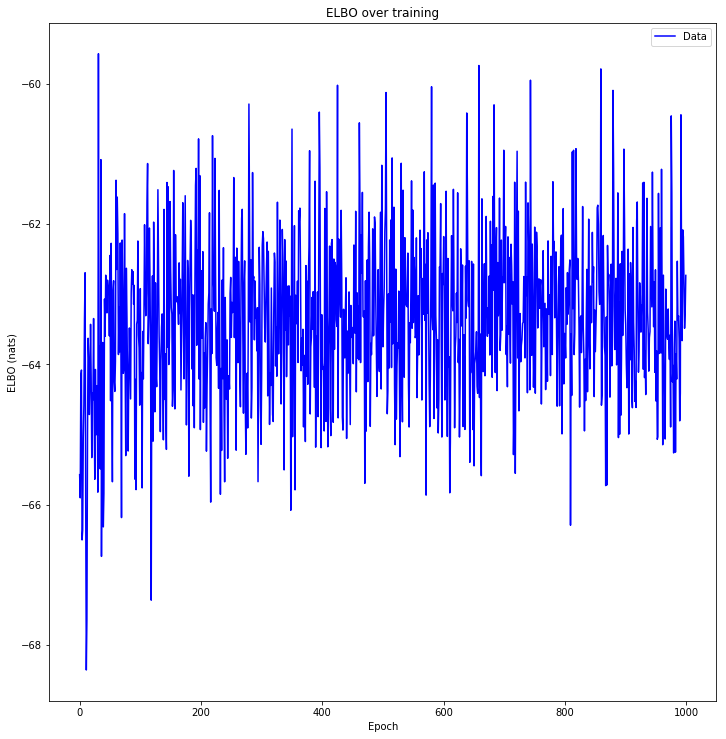

In [13]:
utils.plot_evidence_bounds(elbos)

In [14]:
for t in range(1, zs.shape[0]):
    key = generative.find(lambda k, v: ('Z_%d' % t) in k)[0]
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 1: 0.978795
SMC MSE at time 2: 0.893023
SMC MSE at time 3: 1.678541
SMC MSE at time 4: 0.526687
SMC MSE at time 5: 0.992552
SMC MSE at time 6: 1.638160
SMC MSE at time 7: 0.846198
SMC MSE at time 8: 1.232223
SMC MSE at time 9: 0.930629
SMC MSE at time 10: 1.189546
SMC MSE at time 11: 1.945765
SMC MSE at time 12: 1.040978
SMC MSE at time 13: 1.196839
SMC MSE at time 14: 1.096745
SMC MSE at time 15: 0.867168
SMC MSE at time 16: 0.874504
SMC MSE at time 17: 1.086850
SMC MSE at time 18: 1.150645
SMC MSE at time 19: 2.984694
SMC MSE at time 20: 1.927637
SMC MSE at time 21: 1.099987
SMC MSE at time 22: 0.860882
SMC MSE at time 23: 1.467247
SMC MSE at time 24: 2.042229
SMC MSE at time 25: 2.094040
SMC MSE at time 26: 1.141814
SMC MSE at time 27: 1.062958
SMC MSE at time 28: 1.785161
SMC MSE at time 29: 1.582672
SMC MSE at time 30: 1.271333
SMC MSE at time 31: 1.030350
SMC MSE at time 32: 0.798372
SMC MSE at time 33: 1.923253
SMC MSE at time 34: 1.470836
SMC MSE at time 35: 1.0

In [15]:
particle_mh = mcmc.IndependentMH(ssm_score, 1000)

In [16]:
lookup = utils.dict_lookup(data)
inference = trace_tries.HierarchicalTrace(observations=lookup)
samples, inference = particle_mh(trace=inference)

In [17]:
inference

In [18]:
generative

In [19]:
for t in range(1, zs.shape[0]):
    key = generative.find(lambda k, v: ('Z_%d' % t) in k)[0]
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

KeyError: 'Reduce(ssm_step)'

In [ ]:
elbos